

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Oslo, Norway</font></h1>

Oslo is the capital, economic and governmental centre of Norway. This make it attractive for professionals aiming to build carriere and building experience. 
Oslo was ranked number one in terms of quality of life among European large cities in the European Cities, but it’s a very expensive city as well. 
This notebook is dedicated to the Capstone project, aiming to help finding a suitable place to live in Oslo.


## Download all necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium 
import requests 
import matplotlib as mpl
import matplotlib.pyplot as plt
print('Libraries imported.')

     |████████████████████████████████| 102kB 6.5MB/s ta 0:00:011
Libraries imported.


<a id='item1'></a>

## Data wrangling

Oslo has a total of 15 boroughs. 
This dataset exists for free in **Wikipedia**: https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo#Borough_structure_1988%E2%80%932004.

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo#Borough_structure_1988%E2%80%932004')
df=df[0]
df

,Borough,Residents,Area,Number
0,Alna,49 801,"13,7 km2",12
1,Bjerke,33 422,"7,7 km2",9
2,Frogner,59 269,"8,3 km2",5
3,Gamle Oslo,58 671,"7,5 km2",1
4,Grorud,27 707,"8,2 km2",10
5,Grünerløkka,62 423,"4,8 km2",2
6,Nordre Aker,52 327,"13,6 km2",8
7,Nordstrand,52 459,"16,9 km2",14
8,Sagene,45 089,"3,1 km2",3
9,St. Hanshaugen,38 945,"3,6 km2",4


Drop the columns with information which we will not use

In [3]:
df.drop(df.columns[[1, 2, 3]], axis = 1, inplace = True) 
df = df.reindex(columns = df.columns.tolist())
df

,Borough
0,Alna
1,Bjerke
2,Frogner
3,Gamle Oslo
4,Grorud
5,Grünerløkka
6,Nordre Aker
7,Nordstrand
8,Sagene
9,St. Hanshaugen


Add coordinates of boroughs to the dataset

In [5]:
df1 = df.copy()
latlon = df1.Borough.apply(lambda addr: geolocator.geocode(addr))
df1["Latitude"] = [x.latitude for x in latlon]
df1["Longitude"] = [x.longitude for x in latlon]

In [6]:
df1 # check the dataframe and the data received

,Borough,Latitude,Longitude
0,Alna,59.932417,10.835276
1,Bjerke,59.941395,10.829208
2,Frogner,59.922224,10.706649
3,Gamle Oslo,59.899237,10.734767
4,Grorud,59.961424,10.880549
5,Grünerløkka,59.925471,10.777421
6,Nordre Aker,59.953638,10.756412
7,Nordstrand,54.487378,8.865286
8,Sagene,59.938273,10.765849
9,St. Hanshaugen,59.927950,10.738958


Noticed that coordinates for Nordstrand are too much differ from the rest of Olso data. After checking the Google maps, found out that data should be: 59.8836 and 10.7857. This data to be fixed manually.

In [7]:
df1.at[7,'Latitude'] = 59.8836
df1.at[7,'Longitude'] = 10.7857
df_oslo=df1
df_oslo # check the data after fixing

,Borough,Latitude,Longitude
0,Alna,59.932417,10.835276
1,Bjerke,59.941395,10.829208
2,Frogner,59.922224,10.706649
3,Gamle Oslo,59.899237,10.734767
4,Grorud,59.961424,10.880549
5,Grünerløkka,59.925471,10.777421
6,Nordre Aker,59.953638,10.756412
7,Nordstrand,59.883600,10.785700
8,Sagene,59.938273,10.765849
9,St. Hanshaugen,59.927950,10.738958


In [8]:
df_oslo.dtypes # check the data types

Borough       object
Latitude     float64
Longitude    float64
dtype: object

### Show Oslo boroughs on a map

Get the coordinates of Oslo

In [9]:
address = 'Oslo'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


Passing data to **Folium maps**

In [10]:
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, borough  in zip(df_oslo['Latitude'], df_oslo['Longitude'], df_oslo['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

## Explore the boroughs with the Foursquare

Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = 'Z5XIJP4OATRNTZWDZV4Z0TGZ3EV24X3ITLAW4UVS2EGA1ZTM' # your Foursquare ID
CLIENT_SECRET = 'H3RXA0JXM54B1NDC3FOGQUY4UGF3EUT2Y2T5TMBYEZ3S05PF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Function that extracts the category of the venue

In [12]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Function that get venues for the borough

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Iterate the boroughs in Oslo dataframe

In [19]:
oslo_venues = getNearbyVenues(names=df_oslo['Borough'],latitudes=df_oslo['Latitude'],longitudes=df_oslo['Longitude'])
print(oslo_venues.shape)
oslo_venues.head()

(543, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alna,59.932417,10.835276,BROBEKK STORCASH AS,59.932201,10.831548,Grocery Store
1,Alna,59.932417,10.835276,Meny,59.936573,10.826252,Grocery Store
2,Alna,59.932417,10.835276,Serrano's,59.925757,10.846810,Spanish Restaurant
3,Alna,59.932417,10.835276,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
4,Alna,59.932417,10.835276,Kiwi,59.937958,10.826332,Grocery Store


Check how many venues were returned for each borough

In [20]:
oslo_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Alna,23,23,23,23,23,23
Bjerke,12,12,12,12,12,12
Frogner,100,100,100,100,100,100
Gamle Oslo,23,23,23,23,23,23
Grorud,11,11,11,11,11,11
Grünerløkka,80,80,80,80,80,80
Nordre Aker,22,22,22,22,22,22
Nordstrand,11,11,11,11,11,11
Sagene,83,83,83,83,83,83


Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(oslo_venues['Venue Category'].unique())))

There are 137 uniques categories.


## Analyze Each Borough

In [24]:
#rearrange the data in a dataframe
oslo_arranged = pd.get_dummies(oslo_venues[['Venue Category']], prefix="", prefix_sep="")
oslo_arranged['Borough'] = oslo_venues['Borough'] 
fixed_columns = [oslo_arranged.columns[-1]] + list(oslo_arranged.columns[:-1])
oslo_arranged = oslo_arranged[fixed_columns]
oslo_arranged.shape # check the shape of the dataframe


(543, 138)

In [25]:
oslo_arranged.head() #checking the table

,Borough,Advertising Agency,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Boarding House,Boat or Ferry,Botanical Garden,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Castle,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Creperie,Deli / Bodega,Dessert Shop,Diner,Disc Golf,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Light Rail Station,Market,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Noodle House,Other Nightlife,Park,Performing Arts Venue,Pet Store,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,Rafting,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoothie Shop,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alna,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Group rows by boroughs and by taking the mean of the frequency of occurrence of each category

In [26]:
oslo_grouped = oslo_arranged.groupby('Borough').mean().reset_index()
oslo_grouped

,Borough,Advertising Agency,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Boarding House,Boat or Ferry,Botanical Garden,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Castle,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Creperie,Deli / Bodega,Dessert Shop,Diner,Disc Golf,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Lake,Light Rail Station,Market,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music Venue,Noodle House,Other Nightlife,Park,Performing Arts Venue,Pet Store,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,Rafting,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoothie Shop,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Alna,0.000000,0.0000,0.043478,0.000000,0.000000,0.043478,0.043478,0.00,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.086957,0.000000,0.00,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.043478,0.00,0.000000,0.00,0.000000,0.000000,0.043478,0.00,0.00,0.00,0.086957,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.130435,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.00,0.043478,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.043478,0.130435,0.000000,0.0000,0.0000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.086957,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.043478,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.043478,0.043478,0.0000,0.00,0.0000,0.0000,0.00,0.000000,0.000000
1,Bjerke,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0000,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.083333,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.00,0.083333,0.00,0.083333,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.0000,0.000000,0.000000,0.00,0.0,0.000000,0.250000,0.000000,0.083333,0.000000,0.000000,0.00,0.000000,0.000000,0.0000,0.00,0.083333,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.00,0.000000,0.000000,0.00,0.000000,0.083333,0.000000,0.000000,0.000000,0.083333,0.0000,0.00,0.0000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.083333,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.0000,0.00,0.083333,0.000000
2,Frogne

Confirm the new size

In [27]:
oslo_grouped.shape

(15, 138)

Print each borough along with the top 5 most common venues

In [28]:
num_top_venues = 5

for hood in oslo_grouped['Borough']:
    print("----"+hood+"----")
    temp = oslo_grouped[oslo_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alna----
                    venue  freq
0           Grocery Store  0.13
1           Metro Station  0.13
2  Furniture / Home Store  0.09
3             Bus Station  0.09
4               Pet Store  0.09


----Bjerke----
                  venue  freq
0         Grocery Store  0.25
1  Gym / Fitness Center  0.08
2  Fast Food Restaurant  0.08
3           Supermarket  0.08
4                  Park  0.08


----Frogner----
                     venue  freq
0                   Bakery  0.07
1                     Café  0.06
2              Coffee Shop  0.06
3                    Hotel  0.05
4  Scandinavian Restaurant  0.04


----Gamle Oslo----
                     venue  freq
0            Boat or Ferry  0.26
1                     Pier  0.09
2  Scandinavian Restaurant  0.09
3                   Castle  0.09
4            Historic Site  0.04


----Grorud----
               venue  freq
0      Metro Station  0.18
1      Grocery Store  0.18
2        Pizza Place  0.09
3  Convenience Store  0.09
4        Su

Function to sort the venues in descending order.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each borough

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = oslo_grouped['Borough']

for ind in np.arange(oslo_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oslo_grouped.iloc[ind, :], num_top_venues)

# add average price for square meter for each borough 
# boroughs_venues_sorted.insert(1, 'Price for M2', df_oslo['Price'])

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,Metro Station,Grocery Store,Furniture / Home Store,Pet Store,Bus Station,Spanish Restaurant,Flower Shop,Hotel,Bakery,Automotive Shop
1,Bjerke,Grocery Store,Gym / Fitness Center,Hotel,Supermarket,Park,Café,Farm,Fast Food Restaurant,Pizza Place,Wine Shop
2,Frogner,Bakery,Café,Coffee Shop,Hotel,Indian Restaurant,Scandinavian Restaurant,Burger Joint,Pub,Pizza Place,Grocery Store
3,Gamle Oslo,Boat or Ferry,Pier,Scandinavian Restaurant,Castle,Bay,Other Nightlife,Seafood Restaurant,Café,Mexican Restaurant,Burger Joint
4,Grorud,Metro Station,Grocery Store,Convenience Store,Wine Shop,Asian Restaurant,Athletics & Sports,Pizza Place,Bus Station,Supermarket,Donut Shop
5,Grünerløkka,Grocery Store,Café,Botanical Garden,Coffee Shop,Bar,Bakery,Gym / Fitness Center,Park,Bus Station,Sushi Restaurant
6,Nordre Aker,Bakery,Gym,Asian Restaurant,Metro Station,Shopping Mall,Sushi Restaurant,Grocery Store,Gastropub,Hotel,Pizza Place
7,Nordstrand,Grocery Store,Metro Station,Soccer Field,Pizza Place,Soccer Stadium,Pet Store,Gas Station,Bakery,Light Rail Station,Stadium
8,Sagene,Café,Sushi Restaurant,Coffee Shop,Park,Grocery Store,Pizza Place,Bar,Bakery,Indian Restaurant,Brewery
9,St. Hanshaugen,Bakery,Café,Coffee Shop,Pizza Place,Scandinavian Restaurant,Park,Indian Restaurant,Restaurant,Asian Restaurant,Clothing Store


<a id='item4'></a>

## Cluster Boroughs

Run *k*-means to cluster the boroughs into 5 clusters.

In [31]:
# set number of clusters
kclusters = 5

oslo_grouped_clustering = oslo_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oslo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 3, 0, 4, 3, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3], dtype=int32)

In [32]:
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
boroughs_venues_sorted

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Alna,Metro Station,Grocery Store,Furniture / Home Store,Pet Store,Bus Station,Spanish Restaurant,Flower Shop,Hotel,Bakery,Automotive Shop
1,3,Bjerke,Grocery Store,Gym / Fitness Center,Hotel,Supermarket,Park,Café,Farm,Fast Food Restaurant,Pizza Place,Wine Shop
2,0,Frogner,Bakery,Café,Coffee Shop,Hotel,Indian Restaurant,Scandinavian Restaurant,Burger Joint,Pub,Pizza Place,Grocery Store
3,4,Gamle Oslo,Boat or Ferry,Pier,Scandinavian Restaurant,Castle,Bay,Other Nightlife,Seafood Restaurant,Café,Mexican Restaurant,Burger Joint
4,3,Grorud,Metro Station,Grocery Store,Convenience Store,Wine Shop,Asian Restaurant,Athletics & Sports,Pizza Place,Bus Station,Supermarket,Donut Shop
5,0,Grünerløkka,Grocery Store,Café,Botanical Garden,Coffee Shop,Bar,Bakery,Gym / Fitness Center,Park,Bus Station,Sushi Restaurant
6,0,Nordre Aker,Bakery,Gym,Asian Restaurant,Metro Station,Shopping Mall,Sushi Restaurant,Grocery Store,Gastropub,Hotel,Pizza Place
7,0,Nordstrand,Grocery Store,Metro Station,Soccer Field,Pizza Place,Soccer Stadium,Pet Store,Gas Station,Bakery,Light Rail Station,Stadium
8,0,Sagene,Café,Sushi Restaurant,Coffee Shop,Park,Grocery Store,Pizza Place,Bar,Bakery,Indian Restaurant,Brewery
9,0,St. Hanshaugen,Bakery,Café,Coffee Shop,Pizza Place,Scandinavian Restaurant,Park,Indian Restaurant,Restaurant,Asian Restaurant,Clothing Store


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each borough.

In [33]:
oslo_merged = df_oslo

oslo_merged = oslo_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')
oslo_merged = oslo_merged.dropna()
oslo_merged.reset_index(drop = True, inplace = True)

oslo_merged

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,59.932417,10.835276,3,Metro Station,Grocery Store,Furniture / Home Store,Pet Store,Bus Station,Spanish Restaurant,Flower Shop,Hotel,Bakery,Automotive Shop
1,Bjerke,59.941395,10.829208,3,Grocery Store,Gym / Fitness Center,Hotel,Supermarket,Park,Café,Farm,Fast Food Restaurant,Pizza Place,Wine Shop
2,Frogner,59.922224,10.706649,0,Bakery,Café,Coffee Shop,Hotel,Indian Restaurant,Scandinavian Restaurant,Burger Joint,Pub,Pizza Place,Grocery Store
3,Gamle Oslo,59.899237,10.734767,4,Boat or Ferry,Pier,Scandinavian Restaurant,Castle,Bay,Other Nightlife,Seafood Restaurant,Café,Mexican Restaurant,Burger Joint
4,Grorud,59.961424,10.880549,3,Metro Station,Grocery Store,Convenience Store,Wine Shop,Asian Restaurant,Athletics & Sports,Pizza Place,Bus Station,Supermarket,Donut Shop
5,Grünerløkka,59.925471,10.777421,0,Grocery Store,Café,Botanical Garden,Coffee Shop,Bar,Bakery,Gym / Fitness Center,Park,Bus Station,Sushi Restaurant
6,Nordre Aker,59.953638,10.756412,0,Bakery,Gym,Asian Restaurant,Metro Station,Shopping Mall,Sushi Restaurant,Grocery Store,Gastropub,Hotel,Pizza Place
7,Nordstrand,59.883600,10.785700,0,Grocery Store,Metro Station,Soccer Field,Pizza Place,Soccer Stadium,Pet Store,Gas Station,Bakery,Light Rail Station,Stadium
8,Sagene,59.938273,10.765849,0,Café,Sushi Restaurant,Coffee Shop,Park,Grocery Store,Pizza Place,Bar,Bakery,Indian Restaurant,Brewery
9,St. Hanshaugen,59.927950,10.738958,0,Bakery,Café,Coffee Shop,Pizza Place,Scandinavian Restaurant,Park,Indian Restaurant,Restaurant,Asian Restaurant,Clothing Store


In [34]:
oslo_merged.dtypes

Borough                    object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

Visualize the resulting clusters

In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oslo_merged['Latitude'], oslo_merged['Longitude'], oslo_merged['Borough'], oslo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [41]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 0, oslo_merged.columns[[0] + list(range(5, oslo_merged.shape[1]))]]

,Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Frogner,Café,Coffee Shop,Hotel,Indian Restaurant,Scandinavian Restaurant,Burger Joint,Pub,Pizza Place,Grocery Store
5,Grünerløkka,Café,Botanical Garden,Coffee Shop,Bar,Bakery,Gym / Fitness Center,Park,Bus Station,Sushi Restaurant
6,Nordre Aker,Gym,Asian Restaurant,Metro Station,Shopping Mall,Sushi Restaurant,Grocery Store,Gastropub,Hotel,Pizza Place
7,Nordstrand,Metro Station,Soccer Field,Pizza Place,Soccer Stadium,Pet Store,Gas Station,Bakery,Light Rail Station,Stadium
8,Sagene,Sushi Restaurant,Coffee Shop,Park,Grocery Store,Pizza Place,Bar,Bakery,Indian Restaurant,Brewery
9,St. Hanshaugen,Café,Coffee Shop,Pizza Place,Scandinavian Restaurant,Park,Indian Restaurant,Restaurant,Asian Restaurant,Clothing Store
12,Ullern,Market,Metro Station,Gourmet Shop,Burger Joint,Electronics Store,Convenience Store,Harbor / Marina,Light Rail Station,Flower Shop
13,Vestre Aker,Ski Area,Restaurant,Café,Metro Station,Soccer Field,Lake,Museum,Gas Station,Athletics & Sports


#### Cluster 2

In [42]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 1, oslo_merged.columns[[0] + list(range(5, oslo_merged.shape[1]))]]

,Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Stovner,Athletics & Sports,Grocery Store,Golf Course,Shopping Mall,Yoga Studio,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


#### Cluster 3

In [43]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 2, oslo_merged.columns[[0] + list(range(5, oslo_merged.shape[1]))]]

,Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Søndre Nordstrand,Shopping Mall,Fast Food Restaurant,Gym,Stadium,Train Station,Dog Run,Falafel Restaurant,Electronics Store,Eastern European Restaurant


#### Cluster 4

In [44]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 3, oslo_merged.columns[[0] + list(range(5, oslo_merged.shape[1]))]]

,Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,Grocery Store,Furniture / Home Store,Pet Store,Bus Station,Spanish Restaurant,Flower Shop,Hotel,Bakery,Automotive Shop
1,Bjerke,Gym / Fitness Center,Hotel,Supermarket,Park,Café,Farm,Fast Food Restaurant,Pizza Place,Wine Shop
4,Grorud,Grocery Store,Convenience Store,Wine Shop,Asian Restaurant,Athletics & Sports,Pizza Place,Bus Station,Supermarket,Donut Shop
14,Østensjø,Athletics & Sports,Shopping Mall,Yoga Studio,Supermarket,Grocery Store,Lake,Convenience Store,Pizza Place,Burger Joint


#### Cluster 5

In [45]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 4, oslo_merged.columns[[0] + list(range(5, oslo_merged.shape[1]))]]

,Borough,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Gamle Oslo,Pier,Scandinavian Restaurant,Castle,Bay,Other Nightlife,Seafood Restaurant,Café,Mexican Restaurant,Burger Joint


Add price information to consideration

In [46]:
oslo_merged.head() #check the 

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,59.932417,10.835276,3,Metro Station,Grocery Store,Furniture / Home Store,Pet Store,Bus Station,Spanish Restaurant,Flower Shop,Hotel,Bakery,Automotive Shop
1,Bjerke,59.941395,10.829208,3,Grocery Store,Gym / Fitness Center,Hotel,Supermarket,Park,Café,Farm,Fast Food Restaurant,Pizza Place,Wine Shop
2,Frogner,59.922224,10.706649,0,Bakery,Café,Coffee Shop,Hotel,Indian Restaurant,Scandinavian Restaurant,Burger Joint,Pub,Pizza Place,Grocery Store
3,Gamle Oslo,59.899237,10.734767,4,Boat or Ferry,Pier,Scandinavian Restaurant,Castle,Bay,Other Nightlife,Seafood Restaurant,Café,Mexican Restaurant,Burger Joint
4,Grorud,59.961424,10.880549,3,Metro Station,Grocery Store,Convenience Store,Wine Shop,Asian Restaurant,Athletics & Sports,Pizza Place,Bus Station,Supermarket,Donut Shop


In [335]:
prices_oslo = oslo_merged[['Borough', 'Cluster Labels']].copy()


Add average price for square meter to the dataframe. Read the prices from csv file which was placed to my github repository and merge it to the dataframe.

In [336]:
url = 'https://raw.githubusercontent.com/Julechka/Coursera_Capstone/master/Capstone-oslo-price.csv'
df_csv = pd.read_csv(url)
prices_oslo = pd.merge(prices_oslo, df_csv, on=['Borough'])
prices_oslo

,Borough,Cluster Labels,Price
0,Alna,1,49042
1,Bjerke,1,58834
2,Frogner,1,87923
3,Gamle Oslo,2,74605
4,Grorud,3,49224
5,Grünerløkka,1,76413
6,Nordre Aker,1,78073
7,Nordstrand,0,60350
8,Sagene,1,80766
9,St. Hanshaugen,1,81649


Sort boroughs on price column

In [337]:
prices_oslo = prices_oslo.sort_values(by=['Price'])
prices_oslo

,Borough,Cluster Labels,Price
11,Søndre Nordstrand,4,41235
10,Stovner,0,42394
0,Alna,1,49042
4,Grorud,3,49224
14,Østensjø,3,56556
1,Bjerke,1,58834
7,Nordstrand,0,60350
13,Vestre Aker,0,67186
12,Ullern,1,74109
3,Gamle Oslo,2,74605


Display the prices in a horizontal plot

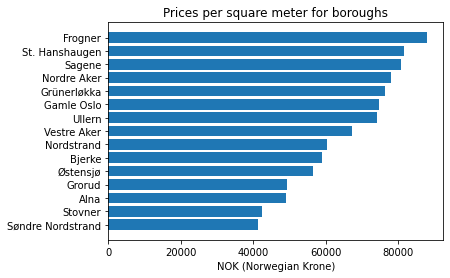

In [338]:
import matplotlib as mpl
import matplotlib.pyplot as plt
y_pos = np.arange(len(prices_oslo['Borough']))
plt.barh(y_pos, prices_oslo['Price'], align='center', alpha=1)
plt.yticks(y_pos, prices_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Prices per square meter for boroughs')
plt.show()

Add Cluster labels to the plot

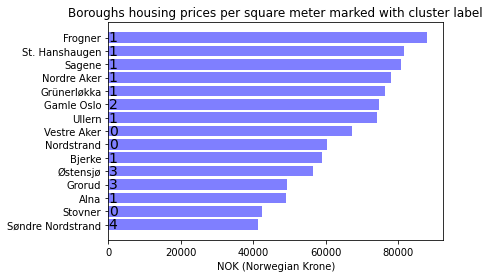

In [339]:
y = prices_oslo['Price']
y1 = prices_oslo['Cluster Labels']
fig, ax = plt.subplots()
# ax.barh(y.index, y, height=0.75)
ax.barh(y_pos, prices_oslo['Price'], align='center', color='blue', alpha=0.5)
y_pos = np.arange(len(prices_oslo['Borough']))
plt.yticks(y_pos, prices_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Boroughs housing prices per square meter marked with cluster label')
for i, v in enumerate(y1):
    ax.text(v + 100, i, str(v), color='black', fontsize=14, ha='left', va='center')
plt.show()

Visualize it grouping by clusters

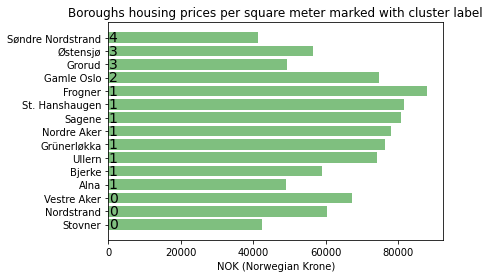

In [341]:
cl_oslo = prices_oslo.sort_values(by=['Cluster Labels'])
y = cl_oslo['Price']
y2 = cl_oslo['Cluster Labels']
fig, ax = plt.subplots()
# ax.barh(y.index, y, height=0.75)
ax.barh(y_pos, y, align='center', color='green', alpha=0.5)
y_pos = np.arange(len(cl_oslo['Borough']))
plt.yticks(y_pos, cl_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Boroughs housing prices per square meter marked with cluster label')
for i, v in enumerate(y2):
    ax.text(v + 100, i, str(v), color='black', fontsize=14, ha='left', va='center')
plt.show()